In [1]:
# ei_net.ipynb
# This notebook is used for testing a network of excitatory and inhibitory units with homeostatic inhibition
# as described in: Moldakarimov, MacClelland and Ermentrout 2006, "A homeostatic rule for inhibitory synapses 
# promotes temporal sharpening and cortical reorganization" PNAS 103(44):16526-16531.

# By Sergio Verduzco Flores        July 2017

from sirasi import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# create some utility functions
def make_fe(th, eps): # returns a function as in Eq. 1 of the paper
    return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
def make_fi(th, eps): # returns a function as in Eq. 2 of the paper
    return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
def make_pulse(t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
    return lambda t : 1. if (t_init < t and t < t_end) else 0.
def make_sin_pulse(t_init, t_end, per): # the actual stimulus used in Moldakarimov et al.
    return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
def r(i,j,sigma): # A Gaussian function with s.d. sigma, applied to i-j
    #return (1./(sigma*np.sqrt(2*np.pi))) * np.exp( -0.5*( ((i-j)/sigma)**2 ) )
    return np.exp(- ((i-j)/sigma)**2 )  # this is what they actually use

Execution time: 1.8816895484924316 seconds
Execution time: 1.300246238708496 seconds


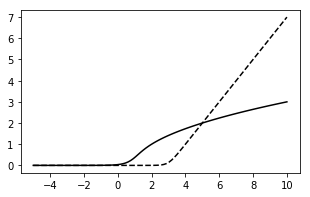

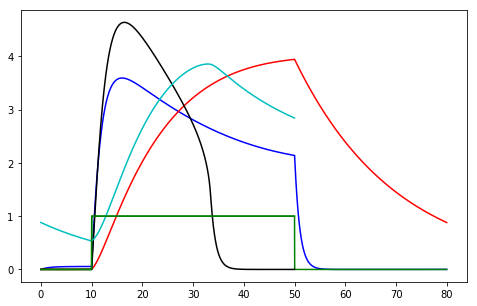

In [3]:
""" Test a single E-I pair, as in figure 2.
    It seems they may have used different durations for the transient stimulus.
    Moreover, the gain functions don't look the same, even if I match their parameters.
"""
net_params = {'min_delay' : 0.01, 'min_buff_size' : 2, 'rtol':1e-5, 'atol':1e-5 } 
net1 = network(net_params)
# creating the units
exc_params = {'tau' : 1., 'function' : make_fe(1., .2), 'type' : unit_types.custom_fi, 'init_val' : 0.0 }
inh_params = {'tau' : 20., 'function' : make_fi(3., .2), 'type' : unit_types.custom_fi, 'init_val' : 0.0 }
ext_params = {'init_val' : 0.0, 'function' : make_pulse(10., 50.), 'type' : unit_types.source, }

exc = net1.create(1, exc_params)
inh = net1.create(1, inh_params)
ext = net1.create(1, ext_params)

# connecting the units 
exc2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
exc2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
inh2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}

exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1.}
exc2exc_syn = {'type' : synapse_types.static, 'init_w' : 3.}
inh2exc_syn = {'type' : synapse_types.static, 'init_w' : -1.5}
ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 5.}
ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 5.}

net1.connect(exc, inh, exc2inh_conn, exc2inh_syn)
net1.connect(exc, exc, exc2exc_conn, exc2exc_syn)
net1.connect(inh, exc, inh2exc_conn, inh2exc_syn)
net1.connect(ext, exc, ext2exc_conn, ext2exc_syn)
net1.connect(ext, inh, ext2inh_conn, ext2inh_syn)

# running the simulation
start_time = time.time()
times, units, empty = net1.run(80.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
gain_fig = plt.figure(figsize=(5,3))
inps = np.linspace(-5.,10.,100)
exc_fr = np.array([net1.units[exc[0]].f(I) for I in inps])
inh_fr = np.array([net1.units[inh[0]].f(I) for I in inps])
plt.plot(inps, exc_fr, 'k', inps, inh_fr, 'k--', figure=gain_fig)

act_fig = plt.figure(figsize=(8,5))
plt.plot(times, units[exc[0]], 'b', times, units[inh[0]], 'r', times, units[ext[0]], 'g', figure=act_fig)

# A second simulation with scaled connections
for syn in net1.syns[exc[0]]:
    if syn.preID == inh[0]:
        syn.w = -3.
    elif syn.preID == exc[0]:
        syn.w = 5.
sim_time = net1.sim_time
net1.units[ext[0]].set_function(make_pulse(sim_time+10.,sim_time+50.))
start_time = time.time()
times2, units, empty = net1.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))
times = times2 - sim_time 
plt.plot(times, units[exc[0]], 'k', times, units[inh[0]], 'c', times, units[ext[0]], 'g', figure=act_fig)
plt.show()


Execution time: 1.9528465270996094 seconds
Execution time: 1.3010659217834473 seconds


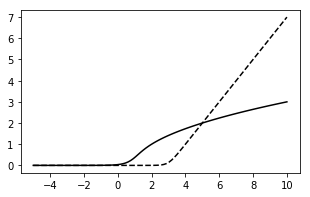

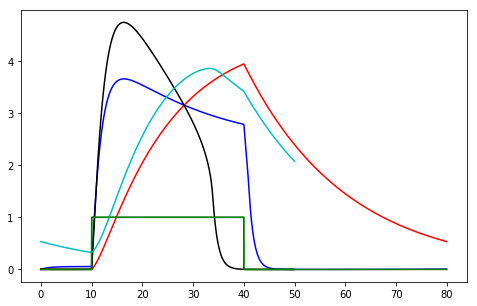

In [4]:
""" A clone of the previous cell, with custom_sc_fi units instead of custom_fi
"""
net_params = {'min_delay' : 0.01, 'min_buff_size' : 2, 'rtol':1e-5, 'atol':1e-5 } 
net1 = network(net_params)
# creating the units
exc_params = {'tau' : 1., 'function' : make_fe(1., 0.2), 'type' : unit_types.custom_sc_fi, 'init_val' : 0.0 }
inh_params = {'tau' : 20., 'function' : make_fi(3., 0.2), 'type' : unit_types.custom_sc_fi, 'init_val' : 0.0 }
width = 30.
ext_params = {'init_val' : 0.0, 'function' : make_pulse(10., 10.+width), 'type' : unit_types.source, }

exc = net1.create(1, exc_params)
inh = net1.create(1, inh_params)
ext = net1.create(1, ext_params)

# connecting the units 
exc2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
exc2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
inh2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2exc_conn = {'rule' : 'one_to_one', 'delay' : 0.01}
ext2inh_conn = {'rule' : 'one_to_one', 'delay' : 0.01}

exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1., 'gain' : 1.}
exc2exc_syn = {'type' : synapse_types.static, 'init_w' : 3., 'gain' : 1.}
inh2exc_syn = {'type' : synapse_types.static, 'init_w' : -1.2, 'gain' : 1.}
ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}
ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 5., 'gain' : 1.}

net1.connect(exc, inh, exc2inh_conn, exc2inh_syn)
net1.connect(exc, exc, exc2exc_conn, exc2exc_syn)
net1.connect(inh, exc, inh2exc_conn, inh2exc_syn)
net1.connect(ext, exc, ext2exc_conn, ext2exc_syn)
net1.connect(ext, inh, ext2inh_conn, ext2inh_syn)

# running the simulation
start_time = time.time()
times, units, empty = net1.run(80.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
gain_fig = plt.figure(figsize=(5,3))
inps = np.linspace(-5.,10.,100)
exc_fr = np.array([net1.units[exc[0]].f(I) for I in inps])
inh_fr = np.array([net1.units[inh[0]].f(I) for I in inps])
plt.plot(inps, exc_fr, 'k', inps, inh_fr, 'k--', figure=gain_fig)

act_fig = plt.figure(figsize=(8,5))
plt.plot(times, units[exc[0]], 'b', times, units[inh[0]], 'r', times, units[ext[0]], 'g', figure=act_fig)

# A second simulation with scaled connections
for syn in net1.syns[exc[0]]:
    if syn.preID == inh[0]:
        syn.w = -3.
    elif syn.preID == exc[0]:
        syn.w = 5.
sim_time = net1.sim_time
net1.units[ext[0]].set_function(make_pulse(sim_time+10.,sim_time+10.+width))
start_time = time.time()
times2, units, empty = net1.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))
times = times2 - sim_time 
plt.plot(times, units[exc[0]], 'k', times, units[inh[0]], 'c', times, units[ext[0]], 'g', figure=act_fig)
plt.show()

In [5]:
""" A class to run sims with the 20 (actually 18) E-I pairs, as in figure 4.
    Default parameters come from homeo+dynamic_thresh.ode.
    Inut is given only to excitatory unit 5.
"""

class ei_net_sim():
    def __init__(self):
    ######## creating the network
        self.md = 0.5 # minimum delay of the connections
        self.width = 35. # width of the input pulse
        self.net_params = {'min_delay' : self.md, 'min_buff_size' : 4, 'rtol':1e-4, 'atol':1e-4 } 
        self.net = network(self.net_params)
        
    ######## creating the units
        self.exc_params = {'tau' : 4., 'function' : make_fe(0.9, 0.2), 'type' : unit_types.custom_sc_fi, 
                           'init_val' : 0.1, 'tau_fast' : 0.1 }
        self.inh_params = {'tau' : 7., 'function' : make_fi(1.0, 0.2), 'type' : unit_types.custom_sc_fi, 
                           'init_val' : 0.1, 'tau_fast' : 0.1 }
        self.ext_params = {'init_val' : 0., 'function' : make_sin_pulse(5., 5.+self.width, self.width), 
                           'type' : unit_types.source }

        self.exc = self.net.create(18, self.exc_params)
        self.inh = self.net.create(18, self.inh_params)
        self.ext = self.net.create(1, self.ext_params)

    ######## connecting the units
        # connection specifications
        exc2inh_conn = {'rule' : 'all_to_all', 'delay' : self.md}
        exc2exc_conn = {'rule' : 'all_to_all', 'delay' : self.md}
        inh2exc_conn = {'rule' : 'all_to_all', 'delay' : self.md}
        ext2exc_conn = {'rule' : 'all_to_all', 'delay' : self.md}
        ext2inh_conn = {'rule' : 'all_to_all', 'delay' : self.md}
        # synapse specifications
        # lrate can be interpreted as the reciprocal of the synaptic time constants.
        self.g_ee=5. 
        self.g_ie=0.8 
        self.g_ei=3.5 # gains for each input type
        exc2inh_syn = {'type' : synapse_types.static, 'init_w' : 1.}
        exc2exc_syn = {'type' : synapse_types.sq_hebbsnorm, 'init_w' : {'distribution':'uniform', 'low':0., 'high':.2},
                       'lrate' : 1./300., 'omega' : 0.5}  
        inh2exc_syn = {'type' : synapse_types.homeo_inh, 'init_w' : {'distribution':'uniform', 'low':-.5, 'high':0.},
                       'lrate' : 1./150., 'des_act' : 0.5, 'gain' : self.g_ei }
        ext2exc_syn = {'type' : synapse_types.static, 'init_w' : 1.2, 'gain' : 1.}
        ext2inh_syn = {'type' : synapse_types.static, 'init_w' : 1., 'gain' : 0.} # Notice the gain 0!
        # neuron-to-neuron connection
        sig = 3. # standard deviation of connection multiplier
        base_e = self.exc[0] # index of first excitatory unit
        base_i = self.inh[0]
        for e,i in zip(self.exc, self.inh):  # connect with non-periodic boundary conditions
            self.net.connect([i], [e], inh2exc_conn, inh2exc_syn) # inhibitory units only connect locally
            for target_e, target_i in zip(self.exc, self.inh):
                if e != target_e:  # no autapses in homeo+dynamic_thresh.ode
                    exc2exc_syn['gain'] = self.g_ee * r(e, target_e, 3.)
                    self.net.connect([e], [target_e], exc2exc_conn, exc2exc_syn)
                exc2inh_syn['gain'] = self.g_ie * r(e-base_e, target_i-base_i, 3.)
                self.net.connect([e], [target_i], exc2inh_conn, exc2inh_syn)
        # external input connections
        self.net.connect(self.ext, [self.exc[5]], ext2exc_conn, ext2exc_syn)
        self.net.connect(self.ext, [self.inh[5]], ext2inh_conn, ext2inh_syn)

    def run(self, n_iters):
        self.act_fig = plt.figure(figsize=(10,8))
        dubyas = []  # to show the evolution of excitatory connections
        for iter in range(1,n_iters+1):
            start_time = time.time()
            times, units, empty = self.net.run(50.)
            if iter == 1: ole_t = times
            print('Execution time: at iteration %d is %s seconds' % (iter, (time.time() - start_time)) )
            sim_time = self.net.sim_time
            self.net.units[self.ext[0]].set_function(make_sin_pulse(sim_time+5, sim_time+5.+self.width, self.width))
            if iter%10 == 0 or iter == 1:
                plt.plot(ole_t, units[self.exc[5]], 'b', ole_t, units[self.inh[5]], 'r', 
                           ole_t, units[self.ext[0]], 'g', figure=self.act_fig)
                dubyas.append([syn.w for syn in self.net.syns[self.exc[5]] if syn.type == synapse_types.sq_hebbsnorm ])
            
        dub_mat = np.matrix(dubyas)
        dub_fig = plt.figure(figsize=(8,6))
        dub_grid = ImageGrid(dub_fig, 111, nrows_ncols=(1,1))
        dub_grid[0].imshow(dub_mat)
        plt.show()

Execution time: at iteration 1 is 2.2204411029815674 seconds
Execution time: at iteration 2 is 2.2006466388702393 seconds
Execution time: at iteration 3 is 2.180203914642334 seconds
Execution time: at iteration 4 is 2.2474334239959717 seconds
Execution time: at iteration 5 is 2.2647788524627686 seconds
Execution time: at iteration 6 is 2.2676076889038086 seconds
Execution time: at iteration 7 is 2.304870367050171 seconds
Execution time: at iteration 8 is 2.328282117843628 seconds
Execution time: at iteration 9 is 2.377756118774414 seconds
Execution time: at iteration 10 is 2.413052558898926 seconds
Execution time: at iteration 11 is 2.4079549312591553 seconds
Execution time: at iteration 12 is 2.4903464317321777 seconds
Execution time: at iteration 13 is 2.529696226119995 seconds
Execution time: at iteration 14 is 2.604633331298828 seconds
Execution time: at iteration 15 is 2.621225595474243 seconds
Execution time: at iteration 16 is 2.590294599533081 seconds
Execution time: at iterati

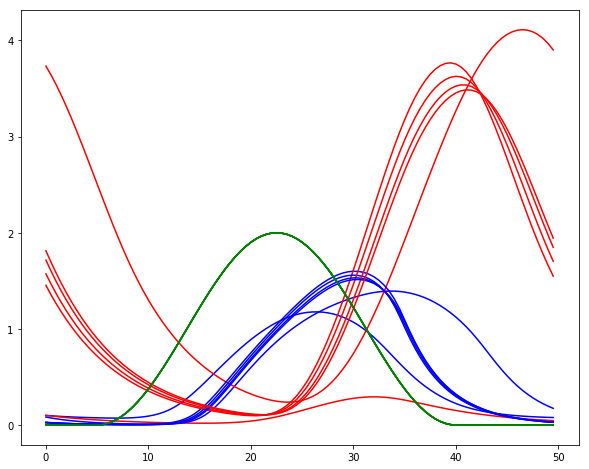

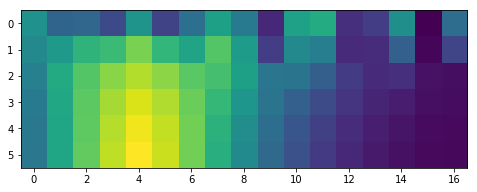

In [6]:
#import cProfile
ei = ei_net_sim()
#cProfile.run('ei.run(36)')
ei.run(50)

Notice that the continued increase requierd for the sharpening probably depends at this point on the sliding threshold for inhibition, which is not included in my inhibitory synapses.

set the inh syn
Execution time: 2.518399477005005 seconds


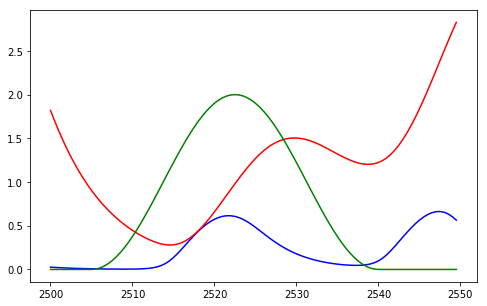

In [7]:
# running the simulation with different input gains
sim_time = ei.net.sim_time
ei.net.units[ei.ext[0]].set_function(make_sin_pulse(sim_time+5,sim_time+40,35))
for exsyn in ei.net.syns[ei.exc[5]]:
    if exsyn.preID == ei.ext[0]:
        exsyn.gain = 1.2  # gain of external input to the excitatory synapse
for insyn in ei.net.syns[ei.inh[5]]:
    if insyn.preID == ei.ext[0]:
        insyn.gain = 1.  # gain of external input to the inhibitory synapse
        print('set the inh syn')
start_time = time.time()
times, units, empty = ei.net.run(50.)
print('Execution time: %s seconds' % (time.time() - start_time))

# visualizing
act_fig = plt.figure(figsize=(8,5))
plt.plot(times, units[ei.exc[5]], 'b', times, units[ei.inh[5]], 'r', times, units[ei.ext[0]], 'g', figure=act_fig)
plt.show()

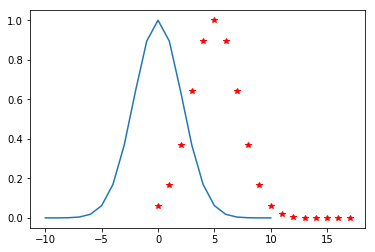

5.2937697548424723

In [8]:
exc_w = [syn.w for syn in ei.net.syns[ei.exc[0]] if syn.type is synapse_types.sq_hebbsnorm]
exc_g = [syn.gain/ei.g_ie for syn in ei.net.syns[ei.inh[5]] if syn.type is synapse_types.static]
exc_g = exc_g[0:18]
int_rang = list(range(-10,11))
gauss = [r(i,0,3) for i in int_rang]
gauss_fig = plt.figure(figsize=(6,4))
plt.plot(int_rang, gauss)
plt.plot(range(0,18), exc_g, 'r*')
plt.show()
sum(exc_g)

In [9]:
[syn.w for syn in ei.net.syns[5]]

[0.135356198248931,
 0.18548745197172717,
 0.23014121148483641,
 0.26792453176375947,
 0.29296079395279317,
 -0.71438835107052634,
 0.27183752482217083,
 0.23774078506219315,
 0.19710451996193382,
 0.15771159568616755,
 0.12419532782109316,
 0.098500626531690449,
 0.078276394113108744,
 0.062779140240191281,
 0.051605414832344335,
 0.043907336595250056,
 0.038314474011475794,
 0.036642706521353485,
 1.2]